In [286]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [287]:
# Dataload
df = pd.read_csv('disney_plus_shows.csv')

# Set theme
sns.set(style="whitegrid")

In [288]:
# Strucuture review
print("Columns dataset:")
print(df.columns)

print("\nFirts rows:")
print(df.head())

Columns dataset:
Index(['imdb_id', 'title', 'plot', 'type', 'rated', 'year', 'released_at',
       'added_at', 'runtime', 'genre', 'director', 'writer', 'actors',
       'language', 'country', 'awards', 'metascore', 'imdb_rating',
       'imdb_votes'],
      dtype='object')

Firts rows:
     imdb_id                                       title  \
0  tt0147800                  10 Things I Hate About You   
1  tt7019028                        101 Dalmatian Street   
2  tt0115433                              101 Dalmatians   
3  tt0324941  101 Dalmatians 2: Patch's London Adventure   
4  tt0211181                              102 Dalmatians   

                                                plot    type  rated   year  \
0  A pretty, popular teenager can't go out on a d...   movie  PG-13   1999   
1  This series follows the lives of Delilah and D...  series    NaN  2018–   
2  An evil high-fashion designer plots to steal D...   movie      G   1996   
3  Being one of 101 takes its toll on P

In [289]:
# Data Cleaning

# Convert imdb_rating to numeric
df["imdb_rating"] = pd.to_numeric(df["imdb_rating"], errors="coerce")

# Clean year column
def clean_year(y):
    if pd.isna(y):
        return np.nan
    y = str(y)
    return int(y[:4]) if y[:4].isdigit() else np.nan

df["year"] = df["year"].apply(clean_year)

# Missing values (delete)
df = df.dropna(subset=["imdb_rating", "year", "rated", "genre"])

print("Shape after cleaning:", df.shape)
print(df[["title", "year", "rated", "genre", "imdb_rating"]].head())


Shape after cleaning: (741, 19)
                                        title    year  rated  \
0                  10 Things I Hate About You  1999.0  PG-13   
2                              101 Dalmatians  1996.0      G   
3  101 Dalmatians 2: Patch's London Adventure  2002.0      G   
4                              102 Dalmatians  2000.0      G   
5                       12 Dates of Christmas  2011.0     PG   

                                           genre  imdb_rating  
0                         Comedy, Drama, Romance          7.3  
2               Adventure, Comedy, Crime, Family          5.7  
3  Animation, Adventure, Comedy, Family, Musical          5.8  
4                      Adventure, Comedy, Family          4.9  
5                       Comedy, Fantasy, Romance          6.3  


In [290]:
print(data.isnull().sum())

imdb_id          0
title            0
plot            17
type             0
rated            0
year             0
released_at      3
added_at         0
runtime         20
genre            3
director        23
writer          70
actors          12
language        19
country         11
awards         269
metascore      414
imdb_rating      0
imdb_votes       0
dtype: int64


In [291]:
# Feature Engineering mpaa_group and main_genre

# MPAA ratings to broader groups

def simplify_mpaa(r):
    if pd.isna(r):
        return np.nan
    r = str(r).upper().strip()

    # Modern MPAA ratings
    if r in ["G", "TV-G", "TV-Y", "TV-Y7"]:
        return "Kids"
    if r in ["PG", "TV-PG"]:
        return "PG"
    if r in ["PG-13", "TV-14"]:
        return "Teen"
    if r in ["R", "TV-MA", "NC-17"]:
        return "Adult"

    # Old MPAA or uncommon labels (Other)
    if r in ["APPROVED", "NOT RATED", "UNRATED", "PASSED"]:
        return "Other"

    return "Other"

df["mpaa_group"] = df["rated"].apply(simplify_mpaa)


# Main genre
def get_main_genre(s):
    if pd.isna(s):
        return np.nan
    return s.split(",")[0].strip()

df["main_genre_raw"] = df["genre"].apply(get_main_genre)


# Group infrequent genres (Other)
genre_counts = df["main_genre_raw"].value_counts()
top_genres = genre_counts[genre_counts >= 20].index 

def simplify_genre(g):
    if g in top_genres:
        return g
    return "Other"

df["main_genre"] = df["main_genre_raw"].apply(simplify_genre)


# Display results
print("Unique mpaa_group:", df["mpaa_group"].unique())
print("Unique main_genre:", df["main_genre"].unique())

Unique mpaa_group: ['Teen' 'Kids' 'PG' 'Other']
Unique main_genre: ['Comedy' 'Adventure' 'Animation' 'Drama' 'Documentary' 'Family' 'Other'
 'Action']


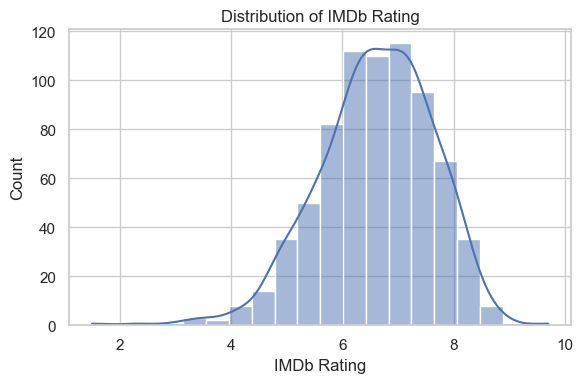

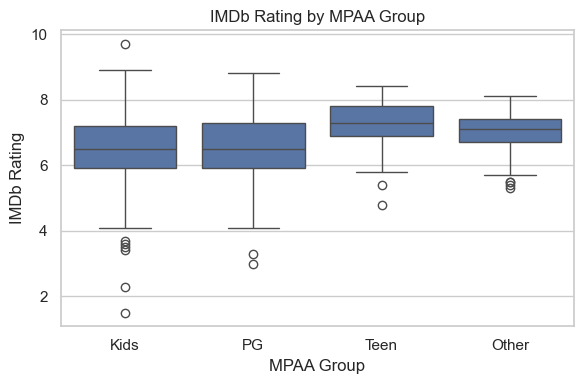

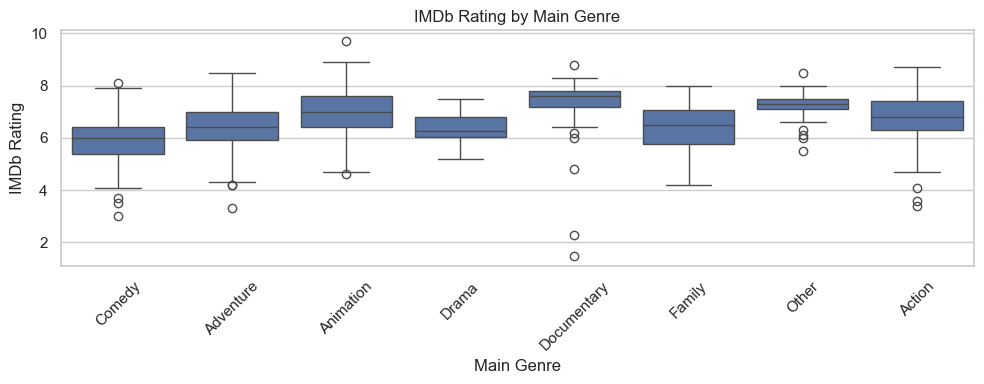

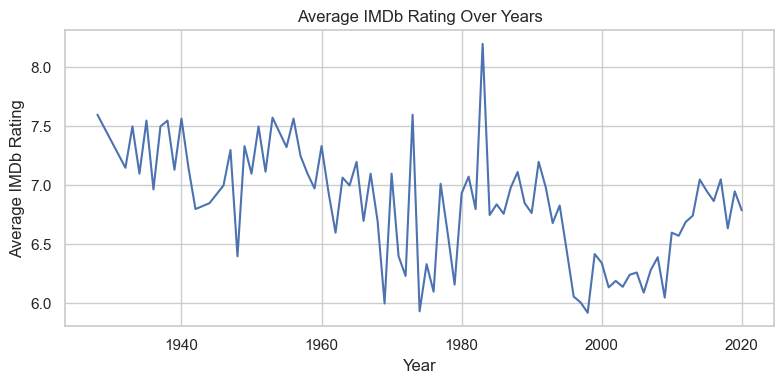

In [292]:
# EDA

# Histogram IMDb rating
plt.figure(figsize=(6,4))
sns.histplot(df["imdb_rating"], kde=True, bins=20)
plt.title("Distribution of IMDb Rating")
plt.xlabel("IMDb Rating")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# Boxplot MPAA group
plt.figure(figsize=(6,4))
sns.boxplot(x="mpaa_group", y="imdb_rating", data=df,
            order=["Kids", "PG", "Teen", "Other"])
plt.title("IMDb Rating by MPAA Group")
plt.xlabel("MPAA Group")
plt.ylabel("IMDb Rating")
plt.tight_layout()
plt.show()

# Boxplot main genre
plt.figure(figsize=(10,4))
sns.boxplot(x="main_genre", y="imdb_rating", data=df)
plt.title("IMDb Rating by Main Genre")
plt.xlabel("Main Genre")
plt.ylabel("IMDb Rating")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Rating per year tendency
year_mean = df.groupby("year")["imdb_rating"].mean().reset_index()

plt.figure(figsize=(8,4))
sns.lineplot(x="year", y="imdb_rating", data=year_mean)
plt.title("Average IMDb Rating Over Years")
plt.xlabel("Year")
plt.ylabel("Average IMDb Rating")
plt.tight_layout()
plt.show()

In [293]:
# Inferential model (OLS Regression)

import statsmodels.formula.api as smf
import statsmodels.api as sm

# Dataset for the regression
df_model = df[["imdb_rating", "year", "mpaa_group", "main_genre"]].dropna()

# Define formula
formula = "imdb_rating ~ year + C(mpaa_group) + C(main_genre)"

# Fit model
model = smf.ols(formula=formula, data=df_model).fit()

# Display results
print(model.summary())

# ANOVA
anova_table = sm.stats.anova_lm(model, typ=2)
print("\nANOVA Table:")
print(anova_table)


                            OLS Regression Results                            
Dep. Variable:            imdb_rating   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.238
Method:                 Least Squares   F-statistic:                     21.96
Date:                Mon, 17 Nov 2025   Prob (F-statistic):           6.61e-39
Time:                        14:09:32   Log-Likelihood:                -966.24
No. Observations:                 741   AIC:                             1956.
Df Residuals:                     729   BIC:                             2012.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       